## Load packages

In [13]:
import pyspark as ps
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.sql.functions import lit

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df lecture") \
            .getOrCreate()

## Load and Preprocess Data 

In [4]:
data='/Users/alejandro/AnacondaProjects/Actuary Data/train_set.csv'
df = spark.read.csv(data,
                   header=True,
                   sep=',',
                   inferSchema=True)

number of lines: 13184290
root
 |-- Row_ID: integer (nullable = true)
 |-- Household_ID: integer (nullable = true)
 |-- Vehicle: integer (nullable = true)
 |-- Calendar_Year: integer (nullable = true)
 |-- Model_Year: integer (nullable = true)
 |-- Blind_Make: string (nullable = true)
 |-- Blind_Model: string (nullable = true)
 |-- Blind_Submodel: string (nullable = true)
 |-- Cat1: string (nullable = true)
 |-- Cat2: string (nullable = true)
 |-- Cat3: string (nullable = true)
 |-- Cat4: string (nullable = true)
 |-- Cat5: string (nullable = true)
 |-- Cat6: string (nullable = true)
 |-- Cat7: string (nullable = true)
 |-- Cat8: string (nullable = true)
 |-- Cat9: string (nullable = true)
 |-- Cat10: string (nullable = true)
 |-- Cat11: string (nullable = true)
 |-- Cat12: string (nullable = true)
 |-- OrdCat: string (nullable = true)
 |-- Var1: double (nullable = true)
 |-- Var2: double (nullable = true)
 |-- Var3: double (nullable = true)
 |-- Var4: double (nullable = true)
 |-- Var

DataFrame[summary: string, Claim_Amount: string]

In [ ]:
print('number of lines:', df.count())
df.printSchema()

In [35]:
df.describe('Claim_Amount').show()

+-------+------------------+
|summary|      Claim_Amount|
+-------+------------------+
|  count|          13184290|
|   mean|1.3606584183791504|
| stddev|39.001034745080645|
|    min|               0.0|
|    max|          11440.75|
+-------+------------------+



In [39]:
dummy_udf = udf(lambda x: 0 if x == 0 else 1)
min_mod_year = df.agg({'Model_Year': 'min'}).collect()[0][0]
df = df.withColumn('model_min', lit(min_mod_year))\
       .withColumn('claim', dummy_udf(col('Claim_Amount')).cast("integer"))\
       .withColumn('Model_Year', col('Model_Year') - col('model_min'))
df.show(1)

+------+------------+-------+-------------+----------+----------+-----------+--------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+------+---------+---------+---------+---------+---------+---------+---------+---------+-----+----------+----------+----------+----------+------------+-----+---------+
|Row_ID|Household_ID|Vehicle|Calendar_Year|Model_Year|Blind_Make|Blind_Model|Blind_Submodel|Cat1|Cat2|Cat3|Cat4|Cat5|Cat6|Cat7|Cat8|Cat9|Cat10|Cat11|Cat12|OrdCat|     Var1|     Var2|     Var3|     Var4|     Var5|     Var6|     Var7|     Var8|NVCat|    NVVar1|    NVVar2|    NVVar3|    NVVar4|Claim_Amount|claim|model_min|
+------+------------+-------+-------------+----------+----------+-----------+--------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+------+---------+---------+---------+---------+---------+---------+---------+---------+-----+----------+----------+----------+----------+------------+-----+---------+
|     1|           1|      3|     

In [40]:
X = df.select(['Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4', 'Vehicle', 'Model_Year', 'Blind_Submodel'])
y = df.select(['claim', 'Claim_Amount'])

In [41]:
# split data into train and test sets
X_train, X_test = X.randomSplit([0.9, 0.1], seed=42)
y_train, y_test = y.randomSplit([0.9, 0.1], seed=42)

In [73]:
cont = [x.name for x in X.schema.fields if x.dataType == DoubleType()]
cat = [x.name for x in X.schema.fields if x.dataType != DoubleType()]

In [72]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler_cont = VectorAssembler(inputCols=cont, outputCol='cont_feat')

X_train_cont = assembler_cont.transform(X_train).select('cont_feat')
scaler = StandardScaler(inputCol="cont_feat", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(X_train_cont)
X_train_cont = scalerModel.transform(X_train_cont).select('scaledFeatures')
X_train_cont.show(5)

+--------------------+--------------------+
|           cont_feat|      scaledFeatures|
+--------------------+--------------------+
|[-3.3503442,-1.28...|[-3.3806127839951...|
|[-3.3503442,-1.28...|[-3.3806127839951...|
|[-3.3503442,-1.28...|[-3.3806127839951...|
|[-3.3503442,-1.28...|[-3.3806127839951...|
|[-3.3503442,-1.28...|[-3.3806127839951...|
+--------------------+--------------------+
only showing top 5 rows



In [98]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCol='Blind_Submodel', 
                              outputCol='catIndex')
model = stringIndexer.fit(X_train)
X_train = model.transform(X_train)

encoder = OneHotEncoder(inputCol='catIndex', outputCol='carModelVect')
X_train = encoder.transform(indexed)

+----------+----------+---------+----------+----------+----------+----------+----------+-------+----------+--------------+--------+-------------------+
|      Var5|      Var6|     Var7|      Var8|    NVVar1|    NVVar2|    NVVar3|    NVVar4|Vehicle|Model_Year|Blind_Submodel|catIndex|       carModelVect|
+----------+----------+---------+----------+----------+----------+----------+----------+-------+----------+--------------+--------+-------------------+
|-3.3503442|-1.2829778|0.6006031|-1.6112602|-0.2315299|-0.2661168|-0.2723372|-0.2514189|      1|         1|        W.14.0|  1239.0|(2733,[1239],[1.0])|
|-3.3503442|-1.2829778|0.6006031|-1.6112602|-0.2315299|-0.2661168|-0.2723372|-0.2514189|      1|         1|        W.14.0|  1239.0|(2733,[1239],[1.0])|
|-3.3503442|-1.2829778|0.6006031|-1.6112602|-0.2315299|-0.2661168|-0.2723372|-0.2514189|      2|         1|        W.14.0|  1239.0|(2733,[1239],[1.0])|
|-3.3503442|-1.2829778|0.6006031|-1.6112602|-0.2315299|-0.2661168|-0.2723372|-0.2514189|

In [102]:
assembler_cat = VectorAssembler(inputCols=['Vehicle', 'Model_Year', 'carModelVect'], 
                                           outputCol='cat_feat')
X_train_cat = assembler_cat.transform(X_train).select('cat_feat') 
X_train_cat.show(5)

+--------------------+
|            cat_feat|
+--------------------+
|(2735,[0,1,1241],...|
|(2735,[0,1,1241],...|
|(2735,[0,1,1241],...|
|(2735,[0,1,1241],...|
|(2735,[0,1,1241],...|
+--------------------+
only showing top 5 rows



In [7]:
def pipeline(X):
    df_cont = pd.DataFrame()
    df_cat = pd.DataFrame()
    for x in X:
        if X[x].dtypes == 'float64':
            df_cont['{}'.format(x)] = X[x]
        else:
            df_cat['{}'.format(x)] = X[x]
    
    dummy = OneHotEncoder()
    dummyC = LabelEncoder()
    
    df_cat2 = np.zeros((df_cat.shape[0], 1))
    for x in df_cat:
        y = dummyC.fit_transform(df_cat[x].reshape(-1, 1))
        y = dummy.fit_transform(y.reshape(-1, 1)).toarray()
        y = pd.DataFrame(y[:, 1:])
        df_cat2 = np.hstack((df_cat2, y))
    df_cat = pd.DataFrame(df_cat2)
    
    pca = PCA(n_components=10)
    pca.fit_transform(df_cat)
    k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95) + 1
    pca = PCA(n_components=k)
    df_cat_pca = pca.fit_transform(df_cat)
    df_cat = pd.DataFrame(df_cat_pca)
    
    return df_cont, df_cat

X_train_cont, X_train_cat = pipeline(X_train)
X_test_cont, X_test_cat = pipeline(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
# scale features to have same variance
sc = StandardScaler()
X_train_cont = sc.fit_transform(X_train_cont)
X_test_cont = sc.transform(X_test_cont)

## Layer 1 - classify claim or no claim using a logistic regression

In [9]:
# fit logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_cont, y_train[:,0])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
# get in and out of sample accuracy
y_pred = model.predict(X_train_cont)
in_acc = accuracy_score(y_pred, y_train[:,0])
y_pred = model.predict(X_test_cont)
out_acc = accuracy_score(y_pred, y_test[:,0])
print('In-sample accuracy: {}\nOut-of-sample accuracy: {}'.format(in_acc, out_acc))

In-sample accuracy: 0.99396
Out-of-sample accuracy: 0.99336


## Layer 2 - predict claim value using a OLS multiple regression

In [11]:
X_train_layer2 = pd.concat([X_train_cat, pd.DataFrame(X_train_cont)], axis=1)
X_train_layer2.head()

,0,0,1,2,3,4,5,6,7,8
0,-0.243031,-0.284310,-0.794956,-0.960135,-0.240450,-0.241578,-0.250954,-0.250451,-0.273503,-1.036118
1,-0.244402,-0.898833,-1.251674,-0.911298,-0.767011,-0.241578,-0.250954,-0.250451,-0.273503,0.274880
2,-0.244075,-0.242547,-0.727650,-0.923507,-0.335940,-0.241578,-0.250954,-0.250451,-0.273503,-0.474262
3,-0.243371,-0.129188,-0.581020,-0.825833,-0.393234,-0.241578,-0.250954,-0.250451,-0.273503,0.649451
4,0.715685,-1.811668,-0.935577,-1.509552,1.285262,5.841606,-0.250954,-0.250451,-0.273503,0.462166


In [12]:
X_test_layer2 = pd.concat([X_test_cat, pd.DataFrame(X_test_cont)], axis=1)
X_test_layer2.head()

,0,0,1,2,3,4,5,6,7,8
0,-0.235519,0.443571,-0.338238,-0.691531,-0.134639,-0.241578,-0.250954,-0.250451,-0.273503,0.462166
1,-0.232630,2.006726,1.701370,1.701484,1.130460,-0.241578,2.466872,-0.250451,-0.273503,0.649451
2,-0.233142,-0.695981,-1.168744,-1.216530,-0.809596,-0.241578,-0.250954,-0.250451,-0.273503,0.462166
3,-0.231103,2.084287,1.239844,1.335206,0.752413,-0.241578,-0.250954,-0.250451,-0.273503,-0.099691
4,-0.291486,-0.505061,-0.656739,-0.654903,0.123956,-0.241578,-0.250954,-0.250451,-0.273503,0.274880


In [13]:
X_train_claims = X_train_layer2[y_train[:,0] == 1]
y_train_claims = y_train[y_train[:,1] != 0, 1]
y_train_claims = np.log(1 + y_train_claims)

X_test_claims = X_test_layer2[y_test[:,0] == 1]
y_test_claims = y_test[y_test[:,1] != 0, 1]
y_test_claims = np.log(1 + y_test_claims)

(array([ 12.,  34.,  59.,  83.,  84.,  63.,  53.,  44.,  16.,   5.]),
 array([ 0.21583112,  0.99223397,  1.76863683,  2.54503968,  3.32144253,
         4.09784539,  4.87424824,  5.65065109,  6.42705394,  7.2034568 ,
         7.97985965]),
 <a list of 10 Patch objects>)

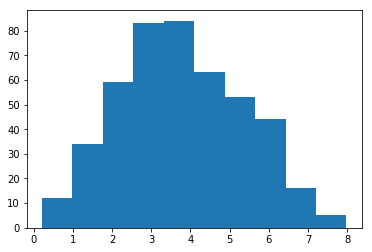

In [14]:
plt.hist(y_train_claims)

In [15]:
regr = LinearRegression()
regr.fit(X_train_claims, y_train_claims)

# get in and out of sample accuracy
y_pred = regr.predict(X_train_claims)
in_acc = np.sqrt(mean_squared_error(y_pred, y_train_claims))
y_pred = regr.predict(X_test_claims)
out_acc = np.sqrt(mean_squared_error(y_pred, y_test_claims))
print('In-sample accuracy: {}\nOut-of-sample accuracy: {}'.format(in_acc, out_acc))

In-sample accuracy: 1.5500161921123283
Out-of-sample accuracy: 1.6490939881971034


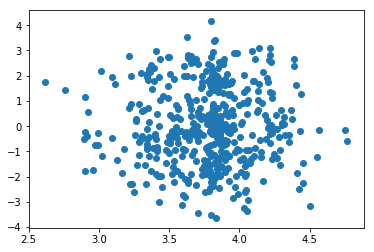

In [16]:
plt.scatter(x=regr.predict(X_train_claims), y=y_train_claims - regr.predict(X_train_claims))

## Join layers 1 and 2 for final predictions

In [17]:
def join_predict(X, model1, model2):
    
    print('loading data...')
    X_cont, X_cat = pipeline(X)
    X_cont = sc.transform(X_cont)    
    df = pd.concat([pd.DataFrame(X_cont), pd.DataFrame(X_cat)], axis=1)
    
    print('clasifying (layer1)...')
    layer1 = model1.predict(X_cont)
    
    print('regressing (layer2)...')
    layer2 = []
    
    for x in layer1:
        if x == 1:
            layer2.append(model2.predict(df))
        else:
            layer2.append(0)
    
    return layer2

In [18]:
y_pred_train = join_predict(X_train, model, regr)

loading data...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


clasifying (layer1)...
regressing (layer2)...


In [29]:
acc = np.sqrt(mean_squared_error(y_pred_train, np.log(1 + y_train[:, 1])))
print('Final model accuracy on train set (in log):', acc)
print('Error for a $100 prediction: +/-  US$', round(np.expm1(2 + acc), 2))
print('Error for a $1000 prediction: +/-  US$', round(np.expm1(3 + acc), 2))

Final model accuracy on train set (in log): 0.317968143981
Error for a $100 prediction: +/-  US$ 9.16
Error for a $1000 prediction: +/-  US$ 26.6


In [20]:
y_pred_test = join_predict(X_test, model, regr)

loading data...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


clasifying (layer1)...
regressing (layer2)...


In [28]:
acc = np.sqrt(mean_squared_error(y_pred_test, np.log(1 + y_test[:, 1])))
print('Final model accuracy on test set (in log):', acc)
print('Error for a $100 prediction: +/-  US$', round(np.expm1(2 + acc), 2))
print('Error for a $1000 prediction: +/-  US$', round(np.expm1(3 + acc), 2))

Final model accuracy on test set (in log): 0.335365218977
Error for a $100 prediction: +/-  US$ 9.33
Error for a $1000 prediction: +/-  US$ 27.09
